# AIA Data introduction

## AIA filters
<img src='int_pap/wave_ion_region_temp.png' >

## AIA instrument characteristics
<img src="int_pap/int_table.png">

### Sampling    
Notice the resolution (1.5 arcsec) of the telescope is different from the pixel size (0.6 arcsec). This is on purpose as pixel size should never equal the resolution. In fact, the resolution should be 2.5 to the pixel size satisfy the Nyquist sampling criterion.  

In [160]:
#Example of Spectral Observation
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


In [161]:
#add tick marks to plots
def fancy_plot(ax):
    """
    Parameters
    ----------
    ax: Axis object
        Axis object you would like nice tick marks on
    Returns
    -------
    ax: Axis object with nice tick marks
    """
    #Turn minor ticks on
    ax.minorticks_on()
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #set the width of the ticks
    ax.tick_params(which='both',width=1)
    #set the length of the major ticks
    ax.tick_params(which='major',length=7)
    #set length of the minor ticks
    ax.tick_params(which='minor',length=3,direction='in')
    ax.tick_params(direction='in')
    return ax

In [162]:
#Unnormalized black body function without physical units
def bb(lam,T=5777):
    """
    Parameters
    -----------
    lam: np.array
        Wavelength of light in Angstroms
    T: float, optional
        Temperature of blackbody object in Kelvin (default = 5777, solar photosphere)
    Returns
    -------
    Array containing unnormalized blackbody shape
    """
    #hc = 12400 eV*Angstroms
    hc = 12400.
    k = 8.6173303E-5 #Boltzmann constant in eV K-1
    kT = k*T #eV
    return (lam**(-5))*(np.exp(hc/(lam*kT))-1.)**(-1)

In [163]:
#Set up some initial variables
#Wavelength
wave = np.linspace(100,350,100000) #Angstroms

#Continuum Intensity assuming a blackbody shape
cont = bb(wave)
#normalize peak to 1
cont /= cont.max()


<IPython.core.display.Javascript object>


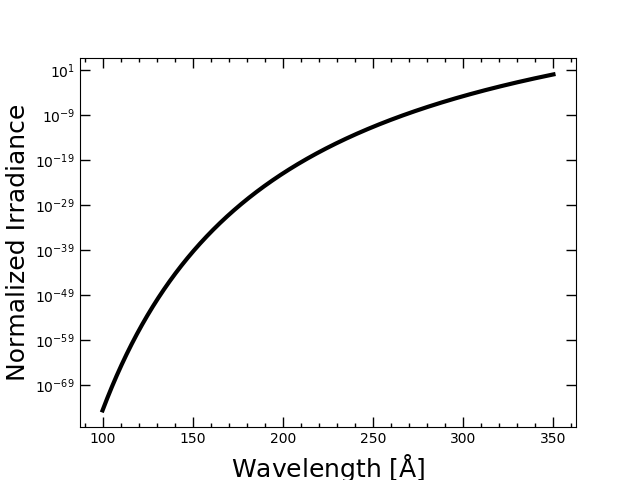

In [164]:
#Plot the blackbody we just created
fig, ax = plt.subplots()

#Plot a line
ax.plot(wave,cont,color='black',linewidth=3)

#Label and tidy up plot
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax.set_ylabel('Normalized Irradiance',fontsize=18)
ax.set_yscale('log')
fancy_plot(ax)

In [112]:
#Fucntion to create a gaussian
def gauss(wav,a,b,c):
    """
    Parameters
    ----------
    wave: np.array
        Array of input wavelengths
    a: float
        Height of input Gaussian
    b: float
        Centeral wavelength of input Gaussian
    c: float
        Sigma squared of input Gaussian
   
    Returns
    -------
    Gaussian values for input parameters
    """
    return a*np.exp(-((wav-b)**2/(2.*c**2)))

In [207]:
#Create Gaussian Fe XII line to add to continuum 
#There is a lot of line physics I am skipping here. Instead I am just making line strengths 
fexii = gauss(wave,.2,195.1,0.5)
#Create Gaussian Fe XXIV line to add to continuum
fexxiv = gauss(wave,.1,192.0,0.3)

<IPython.core.display.Javascript object>


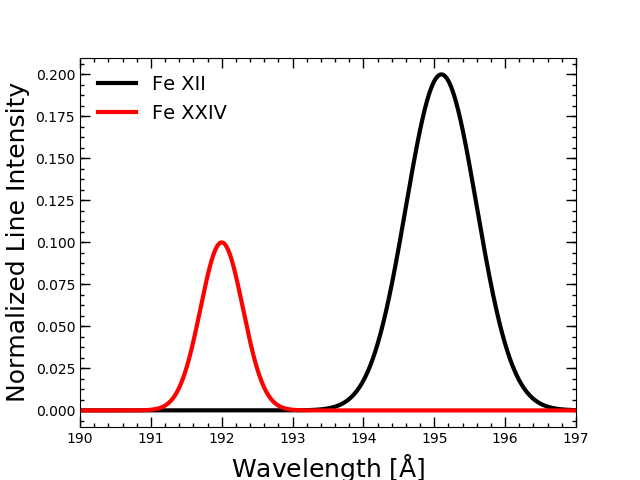

In [216]:
#Plot the lines we just created
fig, ax = plt.subplots()

#Plot Fe XII line
ax.plot(wave,fexii,color='black',linewidth=3,label='Fe XII') 
#Plot Fe XXIV line
ax.plot(wave,fexxiv,color='red',linewidth=3,label='Fe XXIV')


#Label and tidy up plot
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax.set_ylabel('Normalized Line Intensity',fontsize=18)
fancy_plot(ax)

#set plot in restricted range
ax.set_xlim([190.,197.])

#Add legend
ax.legend(loc='upper left',frameon=False,fontsize=14)


<IPython.core.display.Javascript object>


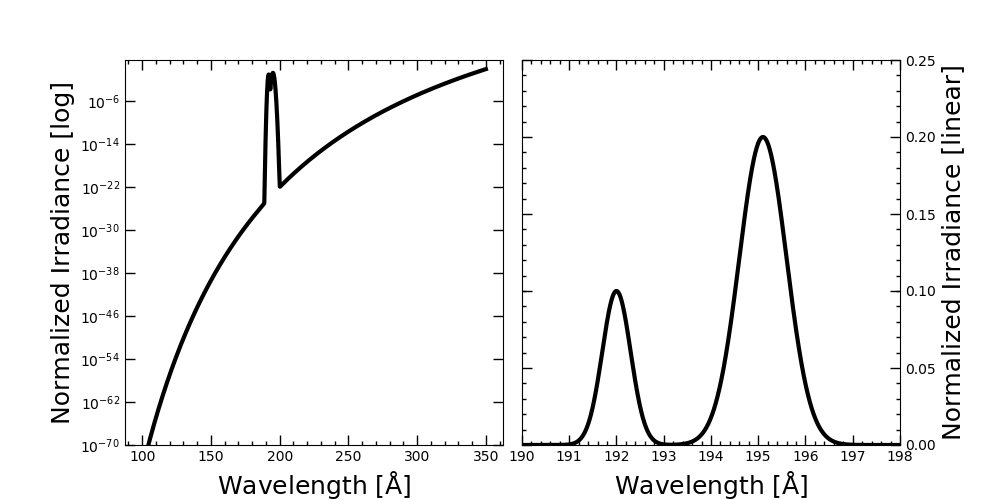

In [236]:
#Create a sudo spectrum by scaling the Fe lines and adding to the continuum
sudo_spec = (fexii+fexxiv)*(1.+cont)+cont
#Plot the spectrum we just created
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.subplots_adjust(wspace=0.05)

#Create two column plot
ax[0].plot(wave,sudo_spec,color='black',linewidth=3)
ax[1].plot(wave,sudo_spec,color='black',linewidth=3)


#set plot in restricted range
ax[1].set_xlim([190.,198.])
ax[1].set_ylim([0,0.25])

#Label and tidy up plot
ax[1].set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax[1].set_ylabel('Normalized Irradiance [linear]',fontsize=18)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

ax[0].set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax[0].set_ylabel('Normalized Irradiance [log]',fontsize=18)
ax[0].set_yscale('log')
ax[0].set_ylim([1E-70,5E1])

fancy_plot(ax[0])
fancy_plot(ax[1])

## Imaging Observed Spectrum
It is difficult to get large field of view (FoV) high wavelength resolution spectra, large FoV high spatial resolution imaging, and high time resolution observations simultaneously. SDO/AIA decided to focus on the latter two.  

### Spectral Resolution
Spectral resolution allows you to differentiate between spectral lines and better understand the physics you are observing. In the above plot you should note that the Fe XII and Fe XXIV lines overlap a bit. This is called line blending. Blending makes it difficult to isolate a line and understand the physics that produced the line. As you go to lower and lower resolutions more lines become blended. Imaging is effectively very low resolution spectra. Below is a quick example showing how blending effects line measurements. As you can see the lowest plotted resolution the two Fe lines become one observed line.

<IPython.core.display.Javascript object>


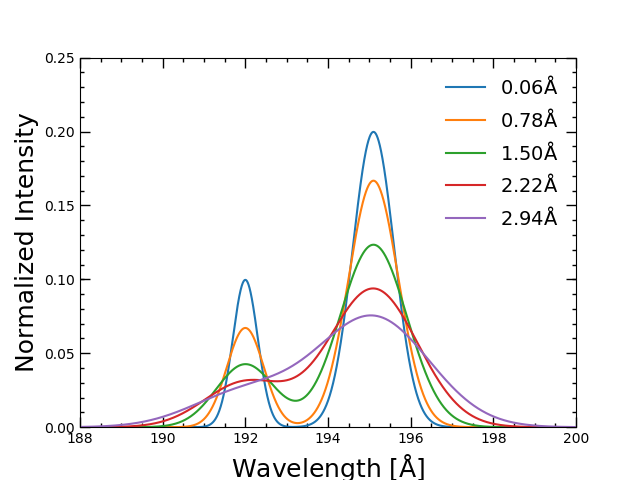

In [261]:
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.modeling import models, fitting

fig, ax = plt.subplots()

#wavelength per pixel
pix_wav = wave[1]-wave[0]

#Quote resolution as a FWHM
fwhm_sig = 2.355

#label format
lab_fmt = '{0:3.2f}'
for i in np.linspace(10,500,5):
    #Create a lower resolution kernal
    g = Gaussian1DKernel(i)
    #Convolve the kernal with the "observed" spectrum
    conv_spec = convolve(sudo_spec,g,boundary='extend')
    #plot the convolved spectrum
    ax.plot(wave,conv_spec,label=lab_fmt.format(i*pix_wav*fwhm_sig)+'$\mathrm{\AA}$')
    

#Label and tidy up plot
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax.set_ylabel('Normalized Intensity',fontsize=18)
fancy_plot(ax)

#set plot in restricted range
ax.set_xlim([188.,200.])
ax.set_ylim([0,0.25])

#Add legend
ax.legend(loc='upper right',frameon=False,fontsize=14)


### Getting AIA response
Unfortunately, there is no reliable way to get the AIA image response from sunpy. Therefore, we must use sswidl for one step. In a new terminal type the following command to get the effective area (wavelength response).   
tcsh> sswidl    
**sswidl> effarea= aia_get_response(/area,/dn,TIMEDEPEND_DATE='2010/06/13 05:30:00',/evenorm)  
sswidl> save,effarea,filename='aia_eff_area_dn.sav'**   
Below are a list of keyword explainations:    


|Keyword | Explaination |  
|:--------|:---------------------- |
|/area   | Get the filter response as a function of wavelength |
|/dn     | Get the filter repsonse in units of cm^2 DN/photon since keyword header is in DN (PIXLUNIT='DN'). |
|TIMEDEPEND_DATE | Date of the observations |
|/evenorm | Normalize so the convolved EVE spectral response is consistent with the observed flux in the SDO/AIA image | 


Then type the following command to get and save the temperature responses.   
**sswidl> efftemp= aia_get_response(/temp,/dn,TIMEDEPEND_DATE='2010/06/13 05:30:00',/evenorm,/chianti)    
sswidl> save,efftemp,filename='aia_eff_temp_dn.sav'**   


|Keyword | Explaination |  
|:--------|:---------------------- |
|/temp   | Get the filter response as a function of temperature |
|/dn     | Above|
|TIMEDEPEND_DATE |Above |
|/evenorm | Above | 
|/chianti | Corrects 131 and 94 bands based on differences between CHIANTI spectra and SDO/AIA temperature responses |





### Reading the filter responses in python
Fortunately, there are python routines to read IDL sav files, and we will use them to continue the analysis in python.

In [210]:
from scipy.io import readsav

In [190]:
#Read in the sav files
effarea = readsav('aia_eff_area_dn.sav')
efftemp = readsav('aia_eff_temp_dn.sav')    

<IPython.core.display.Javascript object>


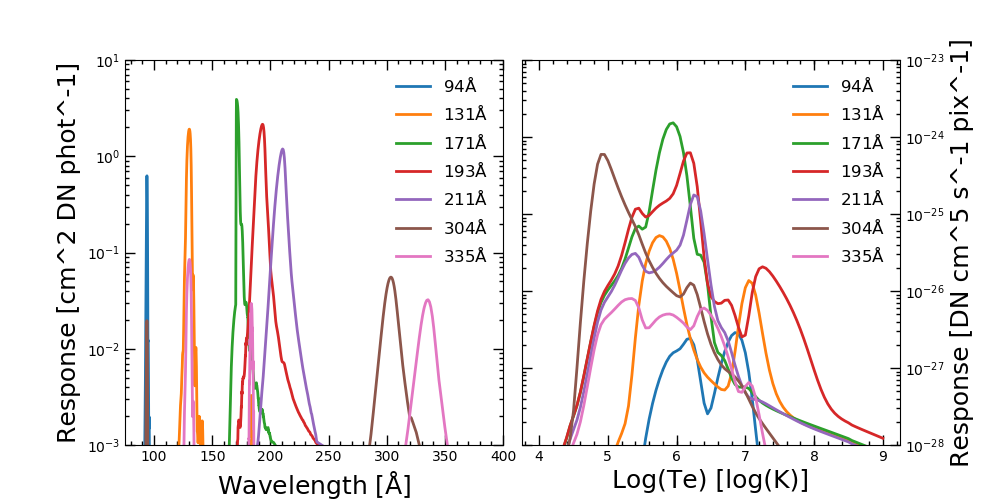

In [262]:
#Create a plot of the effective area and tempurate response functions
keys = ['A94', 'A131', 'A171', 'A193', 'A211', 'A304', 'A335'] #list of keys for differnt AIA filters

#create two panel plot of temperature and area response
fig, ax = plt.subplots(ncols=2,figsize=(10,5))
fig.subplots_adjust(wspace=0.05)

#loop over all keys
for i in keys:
    #shorten variable calls
    dat_area = effarea['effarea'][i][0]
    dat_temp = efftemp['efftemp'][i][0]
    dat_labs = i.replace('A','')+'$\mathrm{\AA}$'
    ax[0].plot(dat_area['wave'][0],dat_area['ea'][0],label=dat_labs,linewidth=2)
    ax[1].plot(dat_temp['logte'][0],dat_temp['tresp'][0],label=dat_labs,linewidth=2)
    
    
#Label and tidy up plot
ax[1].set_xlabel('Log(Te) [log(K)]',fontsize=18)
ax[1].set_ylabel('Response [{0}]'.format(dat_temp['units'][0]),fontsize=18)
ax[1].yaxis.set_label_position("right")
ax[1].set_yscale('log')
ax[1].set_ylim([1E-28,1E-23])
ax[1].yaxis.tick_right()
ax[1].legend(loc='upper right',frameon=False,fontsize=12)

fancy_plot(ax[1])
ax[0].set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax[0].set_ylabel('Response [{0}]'.format(dat_area['units'][0]),fontsize=18)
ax[0].set_yscale('log')
ax[0].legend(loc='upper right',frameon=False,fontsize=12)
ax[0].set_ylim([1e-3,10])
ax[0].set_xlim([75,400])

fancy_plot(ax[0])
fancy_plot(ax[1])

### Effective Area explained
Aeff(λ,t) = AgeoRP(λ)RS(λ)TE(λ)TF(λ)D(λ,t)Q(λ)

|Parameter | Explaination | 
|:----------| :------------- |
| Aeff(λ,t) | Effective area of a filter as a funciton of wavelength and time |
| Ageo      | Goemetric collecting area of telescope  |
| RP(λ)     | Reflectance of primary mirror as a function of wavelength |
| RS(λ)     | Reflectance of secondary mirror as a function of wavelength |
| TE(λ)     | Transmission efficiency for the enterence filter as a function of wavelength |
| TF(λ)     | Transmission efficiency for the focal-plane filter as a function of wavelength |
| D(λ,t)    | Emperical time varying degregration in the observations |
| Q(λ)      | Quantum efficiency as a funciton of wavelength |


Therefore, can get the predicted counts by integrating an intensity spectrum over a spatial scale and multiplying by the effective area.

<IPython.core.display.Javascript object>


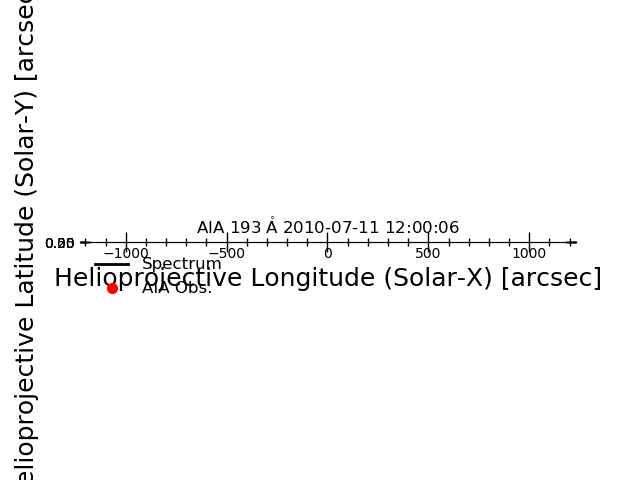

In [265]:
from scipy.interpolate import interp1d

#create lists for populating
tot_cnt = []
wav_fil = []

#get number of counts at each bandpass
#loop over all keys
for i in keys:

    #Get AIA 193 effective area as a function of wavelength
    wave_fil = effarea['effarea'][i][0]['wave'][0]
    area_fil = effarea['effarea'][i][0]['ea'][0]

    #create interpolate object
    intp_fil = interp1d(wave_fil,area_fil,kind='quadratic')

    #Assume sudo_spec is already integrated over a area and multiple by the effective area to get predicted counts in 193
    #Need to interpolate to get match the wavelengths to the same grid
    obs_spec = sudo_spec*intp_fil(wave)
    #Correct counts by a factor to make the plot look nice
    tot_cnt.append(np.sum(obs_spec)/9.E2)
    wav_fil.append(float(i.replace('A','')))
    

fig, ax = plt.subplots()
ax.plot(wave,sudo_spec,color='black',linewidth=2,label='Spectrum')
ax.scatter(wav_fil,tot_cnt,color='red',linewidth=2,label='AIA Obs.')
#set plot in restricted range
ax.set_ylim([0,.3])
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=18)
ax.set_ylabel('Normalized Intensity',fontsize=18)
ax.legend(loc='upper left',fontsize=12,frameon=False)
fancy_plot(ax)

## AIA Observations
See the solar data tutorial for information on how to [obtain](https://github.com/jprchlik/solar_data_tutorial/blob/master/solar_data_worksheet.ipynb) and [prepare](https://github.com/jprchlik/solar_data_tutorial/blob/master/data_prep.ipynb) SDO/AIA observations.

### Opening a fits file
Briefly how to open a SDO/AIA fits file.




In [274]:
from sunpy.net import Fido, attrs
from datetime import datetime, timedelta

#Set a time of interest 2010/07/11 12:00:00 UTC
dttime = datetime(2010,7,11,12,0,0)

#output format for time string
sform = '%Y/%m/%d %H:%M:%S'

#Get time range around a given time
dt = timedelta(seconds=60)

#Get two minutes around dttime and covert to a string
start = datetime.strftime(dttime-dt,sform)
end = datetime.strftime(dttime+dt,sform)
    
#set time span
time = attrs.Time(start,end)
#grabs SDO/AIA observations
ins = attrs.Instrument('aia')

#grab 193 wavelength
wave193 = attrs.Wavelength(193*u.AA)

In [278]:
import os
#Get list of files from VSO
result = Fido.search(time,ins, wave193)
#download the files to the local directory
out_path = os.getcwd()+"/"
#Download the files
dl_fil = Fido.fetch(result,path=out_path,wait=True)


In [279]:
#Output list of downloaded files. One should prep them in SSWIDL 
print(dl_fil)

['aia_lev1_193a_2010_07_11t11_59_06_62z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t11_59_18_60z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t11_59_30_62z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t11_59_42_60z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t11_59_54_62z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t12_00_06_62z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t12_00_18_62z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t12_00_30_63z_image_lev1.fits', 'aia_lev1_193a_2010_07_11t12_00_42_63z_image_lev1.fits']


In [281]:
#I am going to cheat today skip prepping. You should not do this.
import sunpy.map as smap
from astropy.coordinates import SkyCoord
data = smap.Map(dl_fil) #see http://docs.sunpy.org/en/v0.9.0/code_ref/map.html for all map information


/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/sunpy/map/mapbase.py:1699: Warning: This map is not properly oriented. Plot axes may be incorrect
  Warning)


<IPython.core.display.Javascript object>


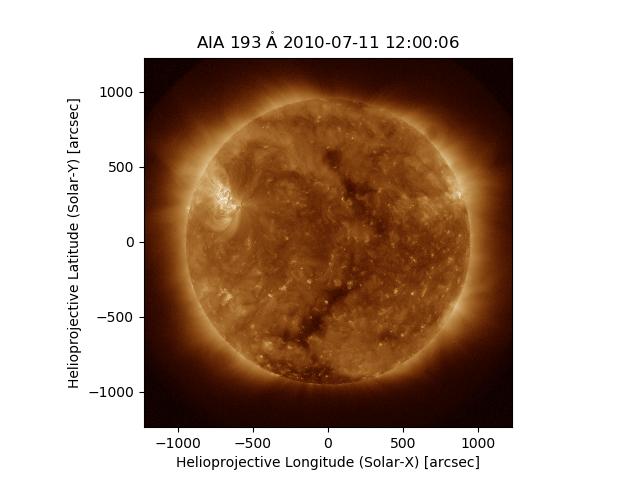

In [288]:
fig, ax = plt.subplots()
data[5].plot()
plt.show()

<IPython.core.display.Javascript object>


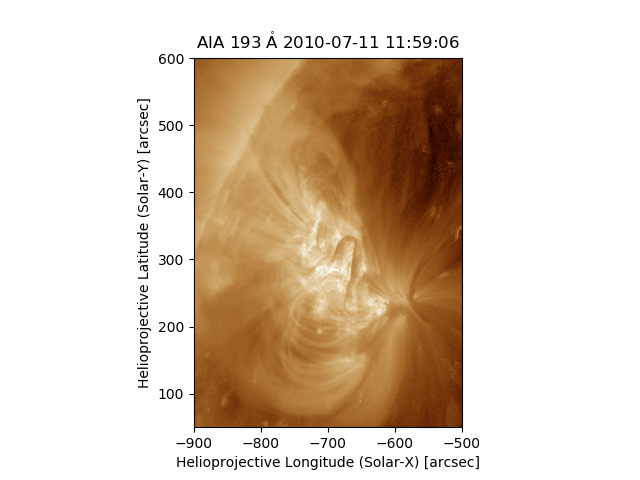

In [292]:
#select a subrange of data
bl = SkyCoord(-900*u.arcsec, 50*u.arcsec, frame=data[0].coordinate_frame)  #bottom left
tr = SkyCoord(-500*u.arcsec, 600*u.arcsec, frame=data[0].coordinate_frame)  #top right
sub_map = data[0].submap(bl, tr) 
fig, ax = plt.subplots()
sub_map.plot()
plt.show()

In [296]:
#Get basic image properties
print(sub_map.mean(),
      sub_map.max(),
      np.sum(sub_map.data))

(1411.0068350104423, 15292, 862085668)


In [303]:
#Add radial filter to image to enhance off limb corona http://docs.sunpy.org/en/v0.9.0/generated/gallery/off_limb_enhance.html
from astropy.visualization.mpl_normalize import ImageNormalize
#Create a pixel grid
x, y = np.meshgrid(*[np.arange(v.value) for v in data[0].dimensions]) * u.pix
#convert pixel grid to arcseconds
hpc_coords = data[0].pixel_to_world(x, y)
#covert arcseconds to radius in arcseconds
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / data[0].rsun_obs

#ste through radii in sun and find mean value
rsun_step_size = 0.1
#create array of radii
rsun_array = np.arange(1, r.max(), rsun_step_size)
#record mean intensity value
y = np.array([data[0].data[(r > this_r) * (r < this_r + rsun_step_size)].mean()
              for this_r in rsun_array])

#Fit a polynomial through mean
params = np.polyfit(rsun_array[rsun_array < 1.5],
                    np.log(y[rsun_array < 1.5]), 1)

#Create scale factor
scale_factor = np.exp((r-1)*-params[0])
scale_factor[r < 1] = 1 #Keeps disk constant

#create scaled map
scaled_map = smap.Map(data[0].data * scale_factor, data[0].meta)
scaled_map.plot_settings['norm'] = ImageNormalize(stretch=data[0].plot_settings['norm'].stretch,
                                                  vmin=data[0].data.min(), vmax=data[0].data.max())


<IPython.core.display.Javascript object>


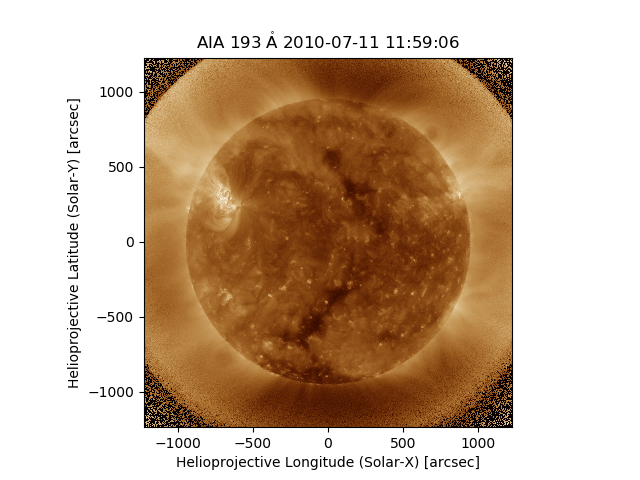

In [304]:
#Plot scaled image
fig, ax = plt.subplots()
scaled_map.plot()
plt.show()

## References
[The Atmospheric Imaging Assembly (AIA) on the Solar Dynamics Observatory (SDO)](https://ui.adsabs.harvard.edu/#abs/2012SoPh..275...17L/abstract)   
[Initial Calibration of the Atmospheric Imaging Assembly (AIA) on the Solar Dynamics Observatory (SDO)](https://ui.adsabs.harvard.edu/?#abs/2012SoPh..275...41B)     
[Photometric and Thermal Cross-calibration of Solar EUV Instruments](https://ui.adsabs.harvard.edu/?#abs/2014SoPh..289.2377B)   
[Solar Corona Loop Studies with the Atmospheric Imaging Assembly. I. Cross-sectional Temperature Structure](https://ui.adsabs.harvard.edu/#abs/2011ApJ...732...81A/abstract)   
[SDO Analysis Guide](http://www.lmsal.com/sdodocs/public_docs/sdo_analysis_guide.html)